In [1]:
%%javascript
IPython.notebook.kernel.execute('version = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# coding=gbk
import os
if os.getcwd()[-9:] == 'notebooks':
    os.chdir("..")
import pickle, datetime, copy
from copy import deepcopy
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas as pd
import utils, utils_eda, utils_train
from evaluator import Evaluator
import evaluator as ev

/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [3]:
# 文件处理参数
PATH_ORI_DATA = r'C:\Users\lucid\Documents\长江实习\课题之自上而下\data'
if_update = False  ## 原始数据文件是否已经更新
use_cache = False  ## 预处理逻辑/参数变更 or 缓存的pickle需要更新时，设为False (注意利用的数据格式，避免用本月行情预测本月行情。)
version = version.split('.')[0]
print('version:', version)

# 预处理参数
if_cls = True
align_to = 'month'
use_lag_x = 15
use_sup = False  ## 纳入美林时钟等补充框架
begT = '2004-01'
endT = datetime.date.today()
asset_sel = []

# 训练参数
n_splits = 10  ## 滚动训练次数
pipe = 'cls'  ## 'benchmark', 'post_FE'(reg), 'cls'
force_train = False  ## 因为每个时间段筛选出的特征不一样，所以必须重新get dump，为了节省时间调试可以False
model_name = 'rf'  ## 'separate'(use topot gen) or specific model name, availables see pipes file

version: dropdup_rf_1016


In [4]:
#############预处理##############
X, y_ret = utils.get_preproc_data(PATH_ORI_DATA, if_update, use_cache, align_to, use_lag_x, use_sup, begT, endT)
if asset_sel:
    y_ret = y_ret.iloc[:, asset_sel]

if if_cls:
    y_cls = utils.reg_to_class(y_ret, 3)
    y = y_cls
else:
    y = y_ret

update: False
os.path.exists(x&y csv): True
...initializing SpecialTreatment

...initializing DataAlignment

...transforming SpecialTreatment 

...transforming DataAlignment 

...initializing GetStationary

...transforming GetStationary 

M5650805 城镇调查失业率  too few data before 2014, need imputer
M6424498 iCPI:总指数:环比  too few data before 2014, need imputer
M6388362 投资景气指数:总体  too few data before 2014, need imputer
M5515072 中期借贷便利(MLF):期末余额  too few data before 2014, need imputer
M5639023 债券市场发行债券:国债  too few data before 2014, need imputer
M6193259 新增投资者数量  too few data before 2014, need imputer
M5543211 私募基金管理人:证券:家数  too few data before 2014, need imputer
M5524546 资产管理业务总规模  too few data before 2014, need imputer
Y0910594 万得一致预测:M1:同比  too few data before 2014, need imputer
M0331593 万得一致预测:社会融资规模:当月值  too few data before 2014, need imputer
M0329545 中期借贷便利(MLF):利率:1年  too few data before 2014, need imputer
V7644905 美国:30年期抵押贷款固定利率与5年期抵押贷款浮动利率利差  too few data before 2014, need imputer
G11

In [5]:
#############训练##############
tscv = TimeSeriesSplit(n_splits=n_splits)
models_list = {}
# 原始的Xy切片之前要deepcopy，否则可能莫名其妙篡改原始数据
for train_index, test_index in tscv.split(X.copy(deep=True)):
    if X.index[len(train_index)] < pd.Period('2015-7'):
        continue
    else:
        X_train, y_train = X.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[train_index, :]
        print("/nTRAIN period:", str(X_train.index[0]), '->', str(X_train.index[-1]),
              "\nStart training.......................")

        models = utils_train.get_models_dump(X_train, y_train, pipe=pipe, version=version, force_train=force_train,
                                             model_name=model_name)
        models_list[str(X_train.index[-1])] = deepcopy(models)

/nTRAIN period: 2005-05 -> 2015-01 
Start training.......................
...initializing MacroFE
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2005-05 -> 2016-07 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2005-05 -> 2018-01 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2005-05 -> 2019-07 
Start training.......................
model 0 pickle loade

In [6]:
#############测试和评估##############
evalor_list = []
for train_index, test_index in tscv.split(X.copy(deep=True)):
    if X.index[len(train_index)] < pd.Period('2015-7'):
        continue
    else:
        X_train, X_test = X.copy(deep=True).iloc[train_index, :], X.copy(deep=True).iloc[test_index, :]
        y_train, y_test = y.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[test_index, :]
        y_test_ret = y_ret.copy(deep=True).loc[y_test.index, :]
        print("\nTEST period:", str(X_test.index[0]), '->', str(X_test.index[-1]),
              "\nStart testing...........................")
        # 增加测试集长度使得FE得以进行
        X_test_long = utils.add_2years_test(X_train, X_test)

        evalor = Evaluator(models_list[str(X_train.index[-1])], if_cls, X_test_long, y_test, y_test_ret, X_train,
                           y_train)
        evalor_list.append(deepcopy(evalor))
        print("Test period:", str(X_test.index[0]), '->', str(X_test.index[-1]), "的年化超额收益为:",
              str(evalor.excess_ann_ret))
        del evalor


TEST period: 2015-02 -> 2016-07 
Start testing...........................

predicting test set for asset 0
...transforming MacroFE
第0个资产的样本外 accuracy score: 0.5

predicting test set for asset 1
...transforming MacroFE
第1个资产的样本外 accuracy score: 0.1111111111111111

predicting test set for asset 2
...transforming MacroFE
第2个资产的样本外 accuracy score: 0.2777777777777778

predicting test set for asset 3
...transforming MacroFE
第3个资产的样本外 accuracy score: 0.3888888888888889

predicting test set for asset 4
...transforming MacroFE
第4个资产的样本外 accuracy score: 0.2777777777777778

predicting test set for asset 5
...transforming MacroFE
第5个资产的样本外 accuracy score: 0.3888888888888889

predicting test set for asset 6
...transforming MacroFE
第6个资产的样本外 accuracy score: 0.16666666666666666

predicting test set for asset 7
...transforming MacroFE
第7个资产的样本外 accuracy score: 0.2777777777777778

predicting test set for asset 8
...transforming MacroFE
第8个资产的样本外 accuracy score: 0.3888888888888889

predicting test set 

In [7]:
exc_rets = [i.excess_ann_ret for i in evalor_list]
port_ws, bench_ws = [i.port_worth for i in evalor_list], [i.bench_worth for i in evalor_list]
scoress = [i.scores for i in evalor_list]
port_poss = [i.port_pos for i in evalor_list]

In [8]:
# 超额收益分析
for i in range(0, len(exc_rets)):    
    print(str(port_ws[i].index[0]), '->', str(port_ws[i].index[-1]), "的年化超额收益为:")
    print(exc_rets[i])

2015-02 -> 2016-07 的年化超额收益为:
return   -0.063617
dtype: float64
2016-08 -> 2018-01 的年化超额收益为:
return   -0.042598
dtype: float64
2018-02 -> 2019-07 的年化超额收益为:
return    0.131081
dtype: float64
2019-08 -> 2021-01 的年化超额收益为:
return    0.069248
dtype: float64
2021-02 -> 2022-07 的年化超额收益为:
return    0.159057
dtype: float64


In [9]:
# 各阶段样本外模型表现
score_df = pd.DataFrame()
for i in scoress:
    score_df = pd.concat([score_df, pd.Series(i)], axis=1)
score_df

,0,0,0,0,0
第0个资产:,0.500000,0.111111,0.222222,0.555556,0.388889
第1个资产:,0.111111,0.166667,0.222222,0.611111,0.555556
第2个资产:,0.277778,0.277778,0.444444,0.555556,0.388889
第3个资产:,0.388889,0.388889,0.333333,0.277778,0.277778
第4个资产:,0.277778,0.444444,0.388889,0.277778,0.388889
第5个资产:,0.388889,0.166667,0.555556,0.444444,0.611111
第6个资产:,0.166667,0.444444,0.222222,0.444444,0.333333
第7个资产:,0.277778,0.277778,0.222222,0.166667,0.222222
第8个资产:,0.388889,0.333333,0.222222,0.555556,0.388889
第9个资产:,0.333333,0.277778,0.722222,0.277778,0.333333


In [10]:
for id, row in score_df.iterrows():
    print(id)
    print(row.mean())

第0个资产:
0.3555555555555555
第1个资产:
0.33333333333333337
第2个资产:
0.3888888888888889
第3个资产:
0.3333333333333333
第4个资产:
0.3555555555555555
第5个资产:
0.4333333333333334
第6个资产:
0.3222222222222222
第7个资产:
0.2333333333333333
第8个资产:
0.37777777777777777
第9个资产:
0.3888888888888889


[]

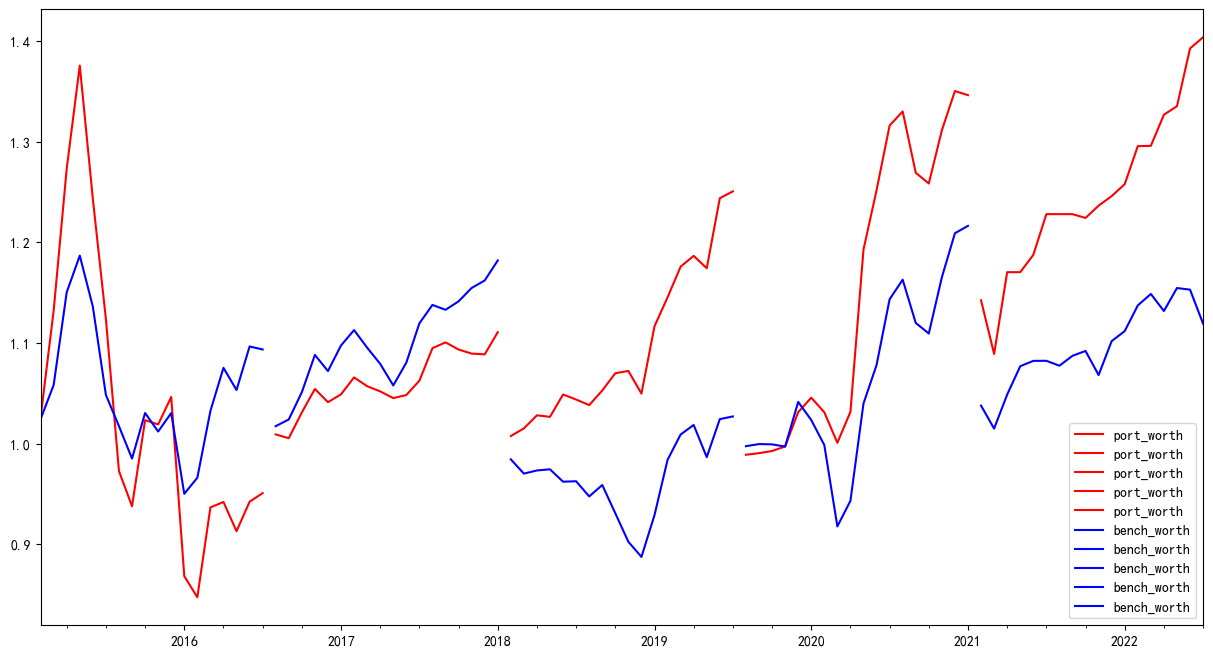

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in port_ws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in bench_ws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()

In [12]:
con_pws = ev.get_continue_worth(port_ws)
con_bws = ev.get_continue_worth(bench_ws)

[]

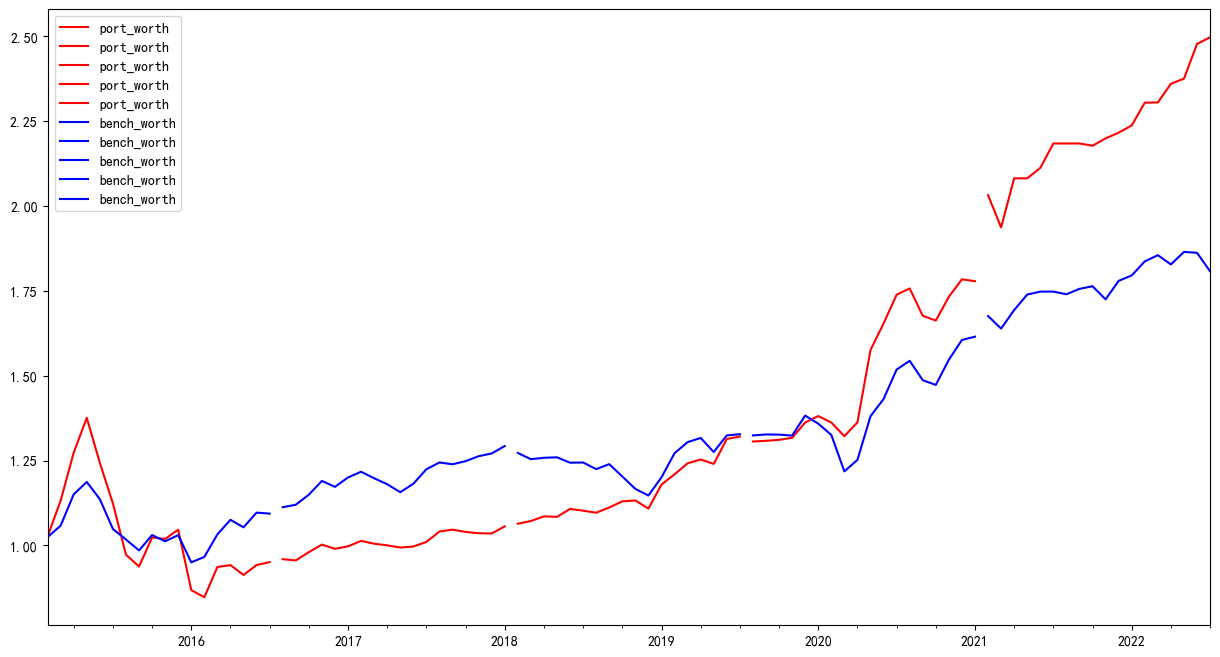

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in con_pws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in con_bws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()

In [14]:
# 宏观因子重要性分析

In [15]:
keys = list(models_list.keys())
keys

['2015-01', '2016-07', '2018-01', '2019-07', '2021-01']

In [16]:
from utils_eda import get_ori_id, get_info, get_ori_name
asset_num = 9
asset_id = get_ori_id(y.columns[asset_num])
asset_name = get_ori_name(asset_id, get_info())
asset_name

'期货结算价(连续):WTI原油'

In [17]:
values=models_list[keys[0]][asset_num][-1][-1].feature_importances_
print(len(values))
names=models_list[keys[0]][asset_num][:-1].get_feature_names_out()
# names = [names[i].split('__')[-1] for i in range(len(names))]
print(len(names))
len(set(names))

94
94


94

In [18]:
# 一些estimator用coef_作为因子重要性
# values=models_list['2016-01'][asset_num][-1][-1].coef_
# values

In [19]:
# 查看单个时间段
# values=models_list['2018-03'][asset_num][-1][-1].feature_importances_
# names=models_list['2018-03'][asset_num][:-1].get_feature_names_out()
# names = [names[i].split('__')[-1] for i in range(len(names))]
# fea_imp = pd.DataFrame([names, values], index=['names', 'values'])
# fea_imp.sort_values(by='values', axis=1, ascending=False)

In [20]:
# 多个时间段整合
fi_df = pd.DataFrame(values, index=names, columns=[keys[0]])
fi_df = fi_df[~fi_df.index.duplicated()]
for i in range(1, len(keys)):
    values=models_list[keys[i]][asset_num][-1][-1].feature_importances_
    names=models_list[keys[i]][asset_num][:-1].get_feature_names_out()
    names = [names[i].split('__')[-1] for i in range(len(names))]
    fi = pd.DataFrame(values, index=names, columns=[keys[i]])
    fi = fi[~fi.index.duplicated()]
    fi_df = pd.concat([fi_df, fi], axis=1)
fi_df

,2015-01,2016-07,2018-01,2019-07,2021-01
pipe_cls__lr1__self__ridge0__var391(t-10)G0003650_resid,0.004321,NaN,NaN,NaN,NaN
pipe_cls__lr1__self__gbr0__var299(t-1)G1100322_resid,0.006881,NaN,NaN,NaN,NaN
pipe_cls__lr1__talibFE__lr0__var7(t-15)M0001427_resid_mom,0.004432,NaN,NaN,NaN,NaN
pipe_cls__lr1__talibFE__lr0__var352(t-11)G1107123_resid_mom,0.002942,NaN,NaN,NaN,NaN
pipe_cls__lr1__talibFE__ridge0__var79(t-14)S0029658_resid_mom,0.002733,NaN,NaN,NaN,NaN
...,...,...,...,...,...
var324(t-12)G1112121,NaN,NaN,NaN,NaN,0.003410
var217(t-10)M5568367,NaN,NaN,NaN,NaN,0.002567
var399(t-6)U1435498,NaN,NaN,NaN,NaN,0.001241
var152(t-4)M0010048_trend,NaN,NaN,NaN,NaN,0.003815


In [21]:
# 统计各指标在不同时期出现次数、重要性加和再排序
fi_df.apply(lambda x: x.sum(), axis=1).sort_values(ascending=False)[:10]

var416(t-1)G1120784_resid            0.126988
var407(t-2)G0003681_resid            0.119201
var407(t-2)G0003681_resid_rsi14      0.117911
var416(t-1)G1120784_resid_ema12      0.097169
var385(t-12)G0003663_resid           0.089126
var307(t-5)G1100344_mom10            0.079067
var203(t-2)M0000610_resid_rsi14      0.062127
var443(t-4)G1119587_resid_rsi6       0.054076
var86(t-3)S0029668                   0.051898
var583(t-6)M0340585_returns_mom10    0.050267
dtype: float64

In [22]:
fi_df.count(axis=1).sort_values(ascending=False)

var3(t-11)M0012303_trend            4
var194(t-3)M0009946                 4
var385(t-12)G0003663_resid          4
var289(t-9)G1109601_resid           4
var416(t-1)G1120784_resid           4
                                   ..
var352(t-4)G1107123_resid_rsi6      1
var352(t-4)G1107123_resid_rsi14     1
var583(t-6)M0340585_returns_rsi6    1
var352(t-8)G1107123_resid_mom       1
var68(t-1)S0113891_resid_mom        1
Length: 362, dtype: int64

In [23]:
# 仓位分析
# 怎么又是熟悉的bug。pycahrm里是没问题的。
# 重新run一遍test，再跑。
# sb notebook的问题

In [24]:
port_positions = [utils_eda.trans_columns_name(i) for i in port_poss]

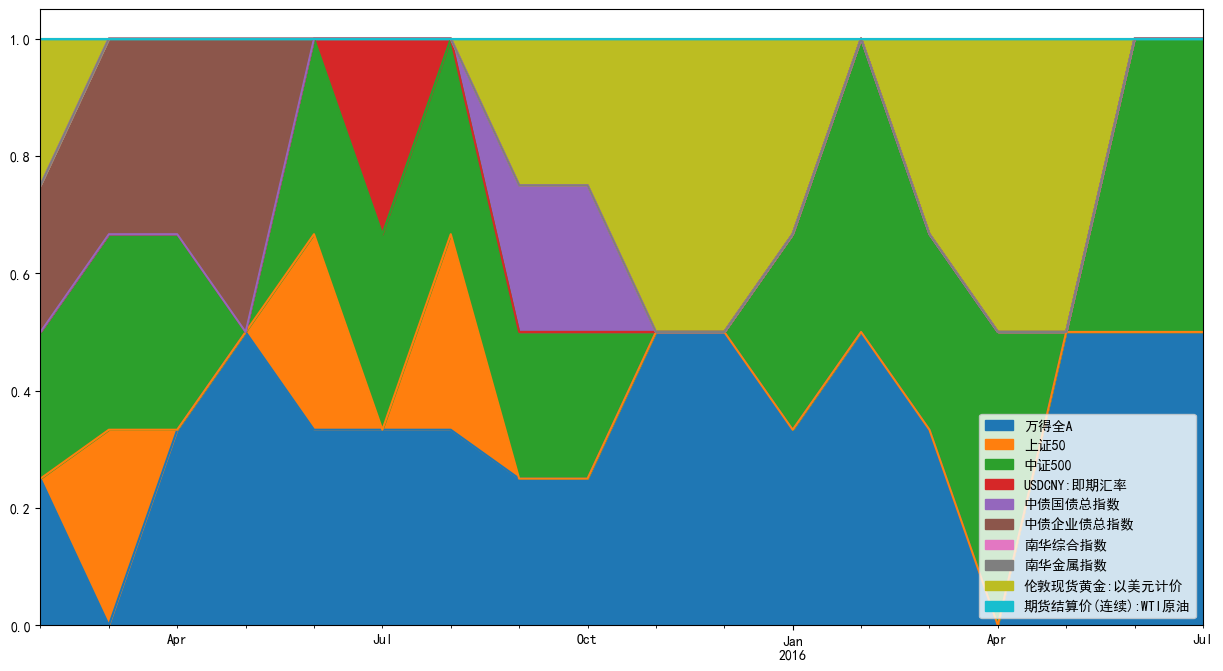

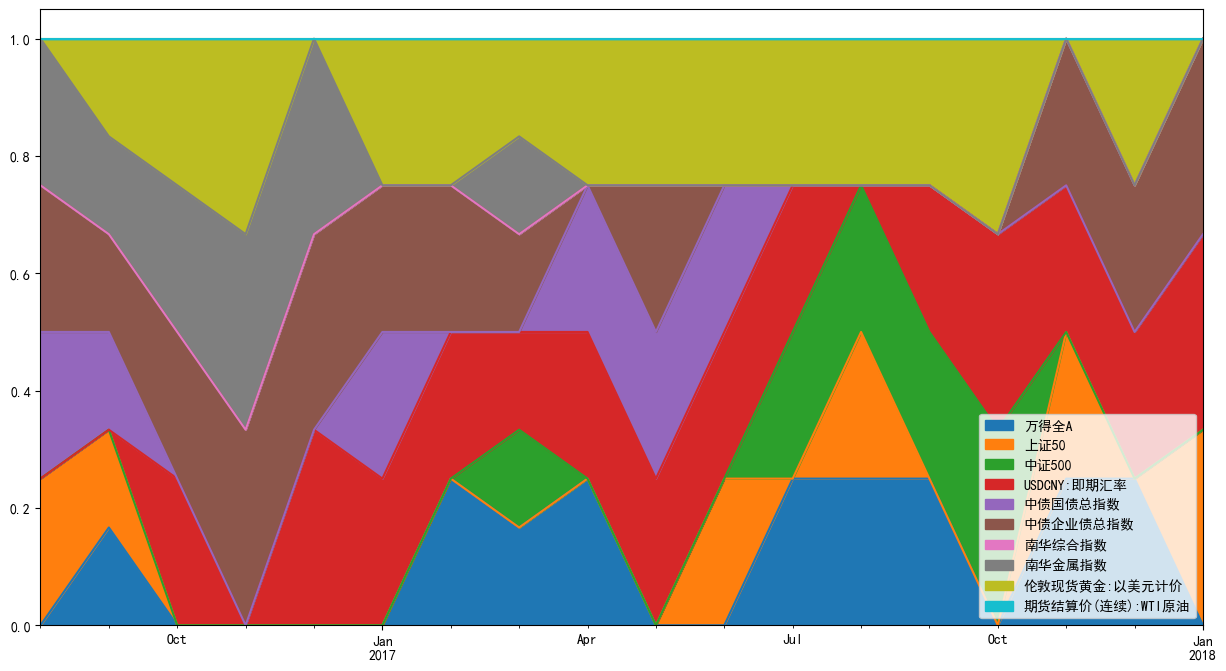

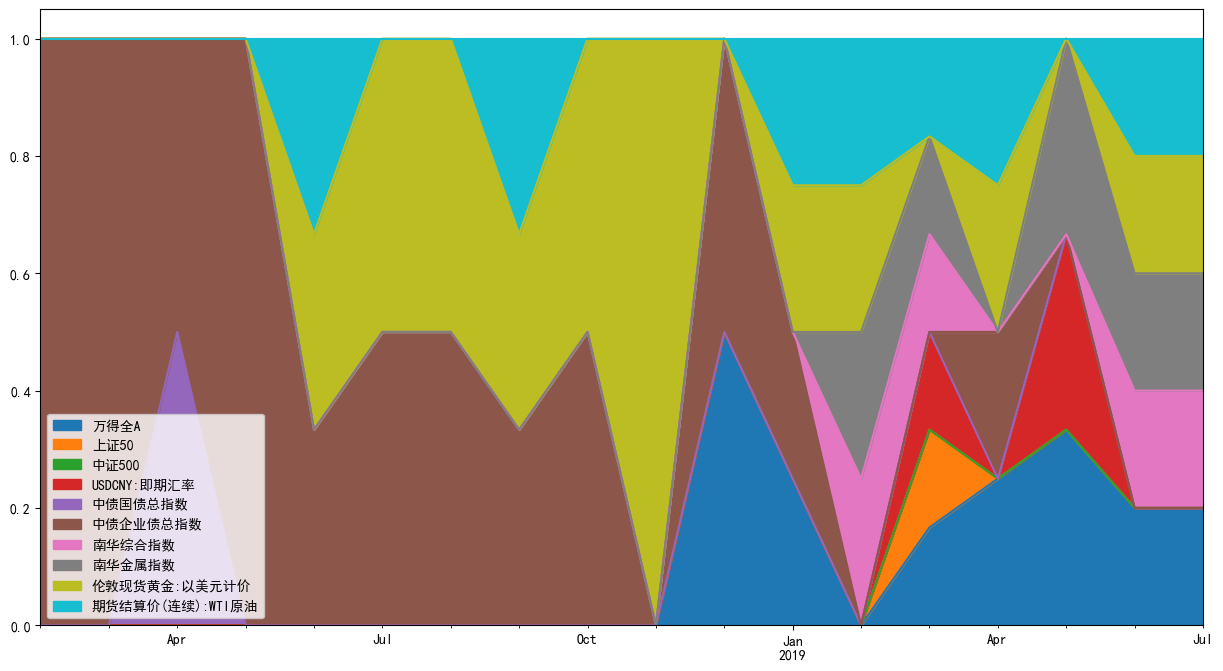

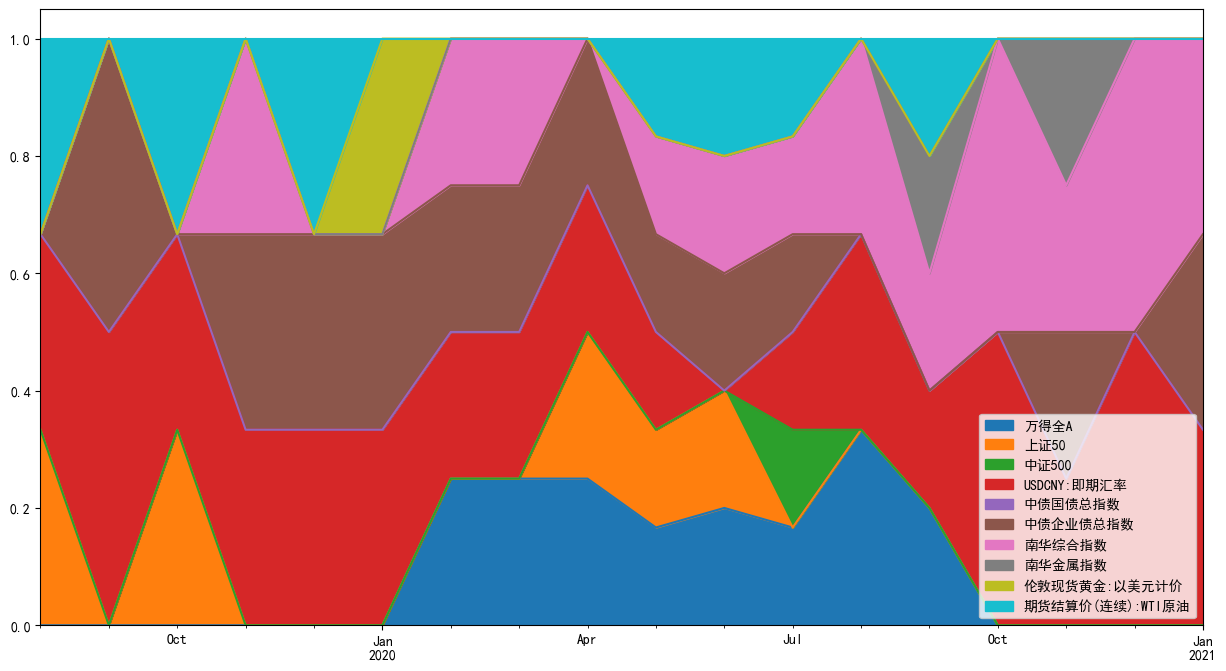

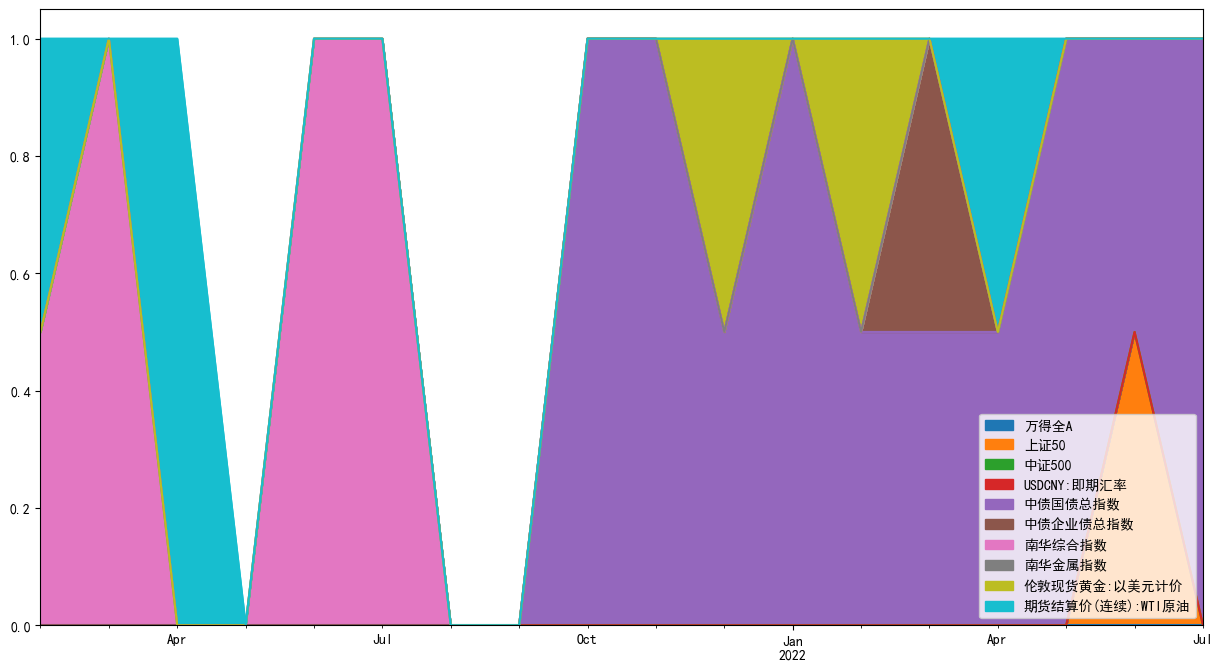

In [25]:
for i in range(len(port_poss)):
    port_positions[i].plot(kind='area',figsize=(15, 8))

In [26]:
好吧 这次没跑stacking而是rf，倒是可以和featcheck1006对比了

SyntaxError: invalid character '，' (U+FF0C) (1061454475.py, line 1)